# DenseNET Implementation

### Importing Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Grayscale
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchsummary
from tqdm import tqdm

### Data Augmentation

Defineing two image preprocessing pipelines using PyTorch’s transforms. Compose—one for training and one for validation/testing. The train_transforms pipeline includes resizing to 224×224 pixels, followed by data augmentation techniques like random horizontal and vertical flips, random rotation, and brightness/contrast jittering to improve model robustness and prevent overfitting. It then converts images to tensors and normalizes them using ImageNet’s mean and standard deviation values. The val_test_transforms pipeline is simpler, applying only resizing, tensor conversion, and normalization to ensure consistent input formatting without altering image content during evaluation.

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        
    transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(20),        
    transforms.RandomVerticalFlip(),      
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),                
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Loading Dataset

Loading an image dataset from the "AlzheimerDataset" directory using PyTorch’s ImageFolder, which expects images to be organized in subdirectories named after their class labels. It applies different transformation pipelines to the training, validation, and test sets. Data augmentation for training and only resizing and normalization for validation and testing. The last two lines print out the list of class names detected in the dataset and the corresponding mapping of each class to a numeric index.

In [3]:
dataset_path = "AlzheimerDataset"

train_data = ImageFolder(root=dataset_path, transform=train_transforms)
val_data = ImageFolder(root=dataset_path, transform=val_test_transforms)
test_data = ImageFolder(root=dataset_path, transform=val_test_transforms)
print(f"Classes: {train_data.classes}")
print(f"Class-to-Index Mapping: {train_data.class_to_idx}")

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Class-to-Index Mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [4]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Number of images per class

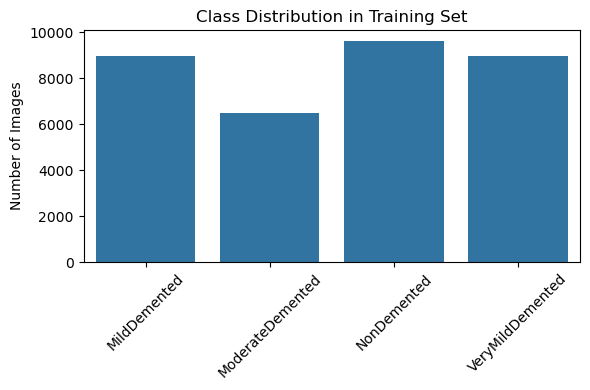

In [5]:
class_counts = Counter([label for _, label in train_data.imgs])
labels = [train_data.classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize = (6, 4))
sns.barplot(x = labels, y = counts)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Training data summary

Statistics

In [6]:
image_shapes = []
for path, _ in train_data.imgs:
    with Image.open(path) as img:
        image_shapes.append(img.size)

shape_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print(shape_df.describe())

              Width        Height
count  33984.000000  33984.000000
mean     196.233522    188.116761
std        7.819527      3.909764
min      180.000000    180.000000
25%      200.000000    190.000000
50%      200.000000    190.000000
75%      200.000000    190.000000
max      200.000000    190.000000


In [7]:
def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

eda_loader = DataLoader(train_data, batch_size=32, shuffle=False, num_workers=2)
mean, std = compute_mean_std(eda_loader)
print("Computed Mean:", mean)
print("Computed Std:", std)

100%|███████████████████████████████████████| 1062/1062 [00:36<00:00, 29.19it/s]

Computed Mean: tensor([-0.8368, -0.7261, -0.5003])
Computed Std: tensor([1.3112, 1.3404, 1.3344])


### Random images from the dataset with class names

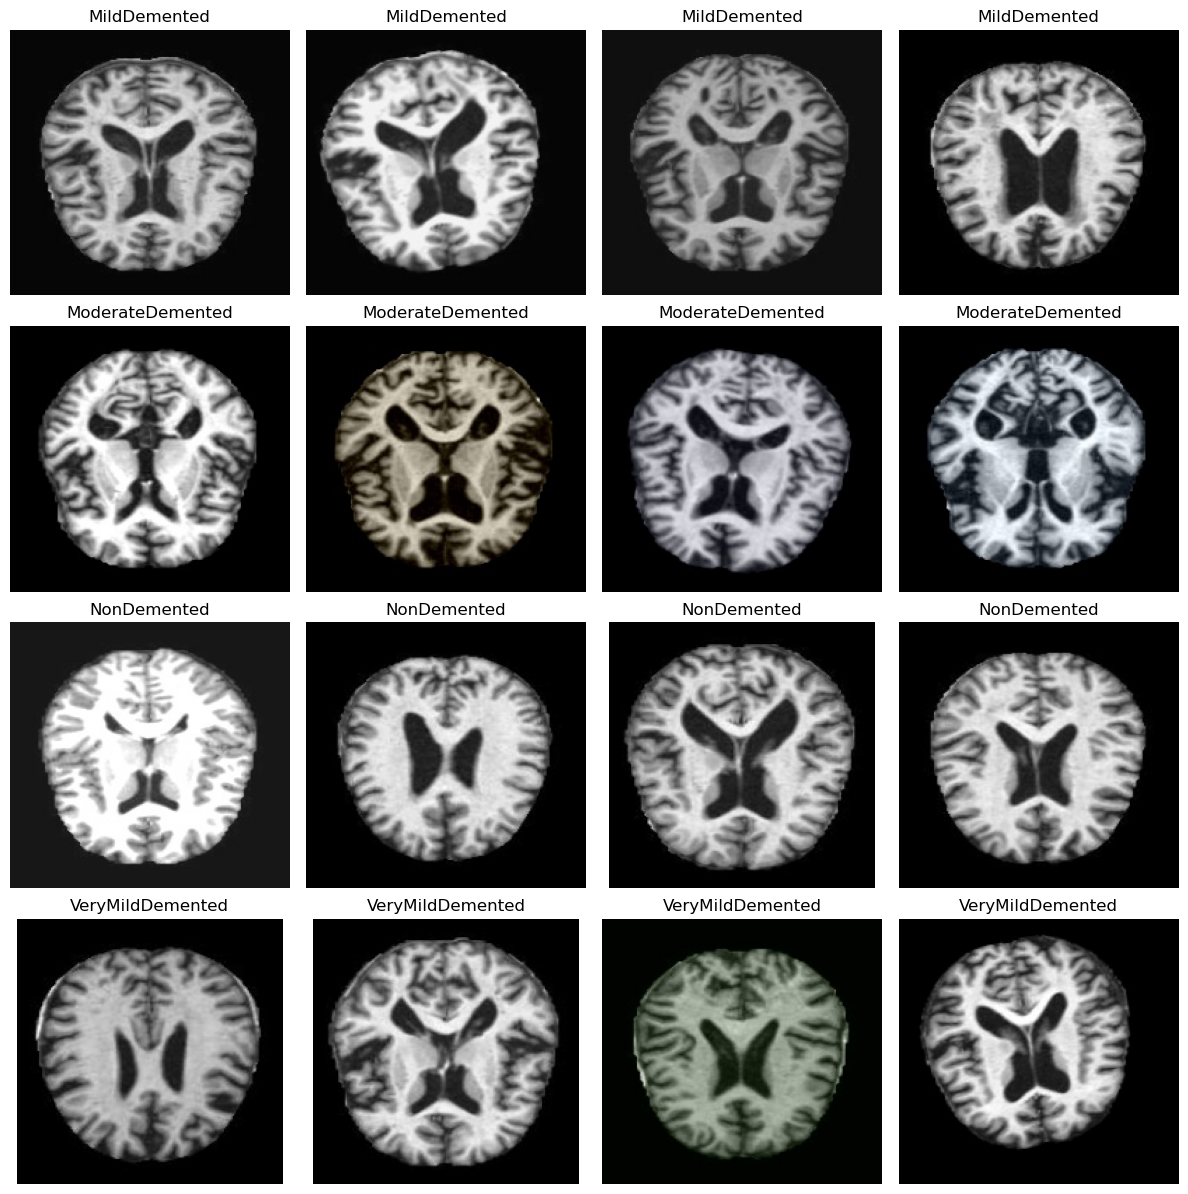

In [8]:
def show_images_by_class(dataset, class_names, samples_per_class=4):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class * 3, len(class_names) * 3))
    for i, class_name in enumerate(class_names):
        class_idx = dataset.class_to_idx[class_name]
        indices = [j for j, (_, label) in enumerate(dataset.imgs) if label == class_idx]
        sampled_indices = random.sample(indices, samples_per_class)
        for k, idx in enumerate(sampled_indices):
            img_path, _ = dataset.imgs[idx]
            image = Image.open(img_path)
            axes[i, k].imshow(image)
            axes[i, k].set_title(class_name)
            axes[i, k].axis("off")
    plt.tight_layout()
    plt.show()

show_images_by_class(train_data, train_data.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0416646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0217083].


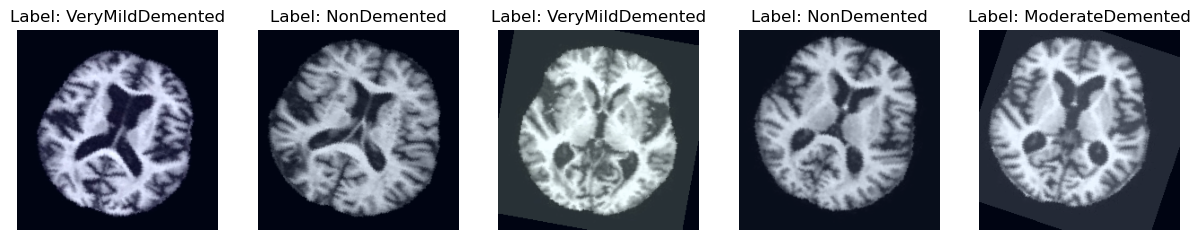

In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))
    image = image * 0.229 + 0.485
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {train_data.classes[labels[i]]}")
    axes[i].axis("off")

plt.show()

### Balancing classes using weighted sampling

Handling class imbalance in the training dataset by applying weighted random sampling. It first counts the number of samples in each class using Counter, then computes class weights inversely proportional to their frequencies—giving higher weights to underrepresented classes. Each training sample is then assigned a corresponding weight. A WeightedRandomSampler is used to sample data such that all classes are represented more evenly during training. This sampler is passed to a DataLoader to ensure balanced batches. Finally, a message confirms that class balancing has been successfully applied.

In [10]:
class_counts = Counter(train_data.targets)
total_count = sum(class_counts.values())
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_data.targets]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, num_workers=2)

print("Class balancing using weighted sampling is applied!")

Class balancing using weighted sampling is applied!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.039215684..1.08956].


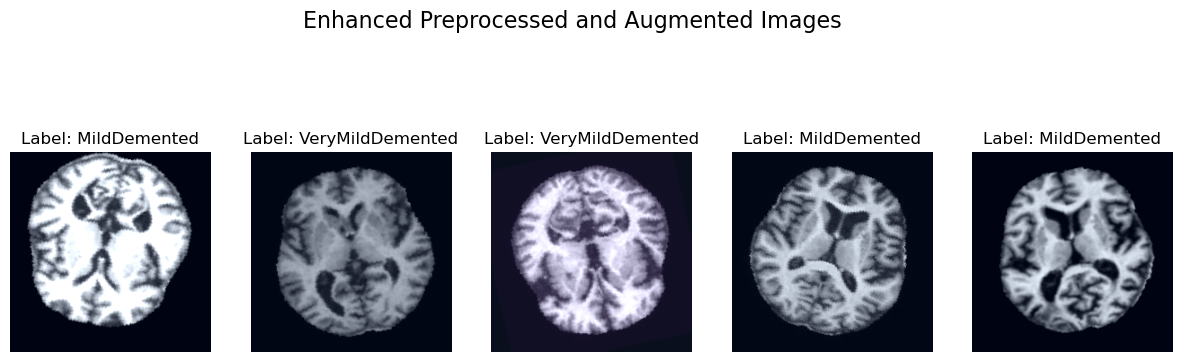

In [11]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))
    image = image * 0.229 + 0.485  # Unnormalize for display
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {train_data.classes[labels[i]]}")
    axes[i].axis("off")

plt.suptitle("Enhanced Preprocessed and Augmented Images", fontsize=16)
plt.show()

In [12]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch Size: {images.size(0)}")
print(f"Image Shape: {images.shape}")
print(f"Image Mean: {images.mean().item():.4f}, Image Std: {images.std().item():.4f}")


Batch Size: 32
Image Shape: torch.Size([32, 3, 224, 224])
Image Mean: -0.7098, Image Std: 1.3826


### Defining DenseNET model

In [18]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(self._make_dense_layer(in_channels + i * growth_rate, growth_rate))

    def _make_dense_layer(self, in_channels, growth_rate):
        return nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        for layer in self.layers:
            new_features = layer(x)
            x = torch.cat((x, new_features), 1)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(2, 2)
        )

    def forward(self, x):
        return self.transition(x)

class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_classes=4):
        super(DenseNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense1 = DenseBlock(64, growth_rate, block_config[0])
        self.trans1 = TransitionLayer(64 + growth_rate * block_config[0], 128)

        self.dense2 = DenseBlock(128, growth_rate, block_config[1])
        self.trans2 = TransitionLayer(128 + growth_rate * block_config[1], 256)

        self.dense3 = DenseBlock(256, growth_rate, block_config[2])
        self.trans3 = TransitionLayer(256 + growth_rate * block_config[2], 512)

        self.dense4 = DenseBlock(512, growth_rate, block_config[3])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 + growth_rate * block_config[3], num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.dense1(x)
        x = self.trans1(x)

        x = self.dense2(x)
        x = self.trans2(x)

        x = self.dense3(x)
        x = self.trans3(x)

        x = self.dense4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), num_classes=4)
from torchsummary import summary

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]          18,432
       BatchNorm2d-8           [-1, 96, 56, 56]             192
              ReLU-9           [-1, 96, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          27,648
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13           [-1, 32, 56, 56]          36,864
      BatchNorm2d-14          [-1, 160,

### Training the model

Using device: mps


Epoch 1/10 [Val]: 100%|█████████████████████| 1062/1062 [05:56<00:00,  2.98it/s]



Epoch 1/10
Train Loss: 1.2157 | Train Acc: 0.4344
Val Loss: 1.1125 | Val Acc: 0.4841
Saved best model with Val Acc: 0.4841


Epoch 2/10 [Val]: 100%|█████████████████████| 1062/1062 [06:21<00:00,  2.78it/s]



Epoch 2/10
Train Loss: 0.9110 | Train Acc: 0.5779
Val Loss: 0.8246 | Val Acc: 0.6190
Saved best model with Val Acc: 0.6190


Epoch 3/10 [Val]: 100%|█████████████████████| 1062/1062 [06:49<00:00,  2.59it/s]



Epoch 3/10
Train Loss: 0.7619 | Train Acc: 0.6382
Val Loss: 0.7992 | Val Acc: 0.6310
Saved best model with Val Acc: 0.6310


Epoch 4/10 [Val]: 100%|█████████████████████| 1062/1062 [06:03<00:00,  2.92it/s]



Epoch 4/10
Train Loss: 0.7005 | Train Acc: 0.6693
Val Loss: 0.8112 | Val Acc: 0.6229


Epoch 5/10 [Val]: 100%|█████████████████████| 1062/1062 [05:18<00:00,  3.33it/s]



Epoch 5/10
Train Loss: 0.6635 | Train Acc: 0.6878
Val Loss: 0.6852 | Val Acc: 0.6778
Saved best model with Val Acc: 0.6778


Epoch 6/10 [Val]: 100%|█████████████████████| 1062/1062 [05:09<00:00,  3.43it/s]



Epoch 6/10
Train Loss: 0.5709 | Train Acc: 0.7336
Val Loss: 0.5438 | Val Acc: 0.7541
Saved best model with Val Acc: 0.7541


Epoch 7/10 [Val]: 100%|█████████████████████| 1062/1062 [05:09<00:00,  3.44it/s]



Epoch 7/10
Train Loss: 0.5338 | Train Acc: 0.7542
Val Loss: 0.5259 | Val Acc: 0.7545
Saved best model with Val Acc: 0.7545


Epoch 8/10 [Val]: 100%|█████████████████████| 1062/1062 [05:08<00:00,  3.45it/s]



Epoch 8/10
Train Loss: 0.4926 | Train Acc: 0.7770
Val Loss: 0.4598 | Val Acc: 0.7973
Saved best model with Val Acc: 0.7973


Epoch 9/10 [Val]: 100%|█████████████████████| 1062/1062 [05:10<00:00,  3.42it/s]



Epoch 9/10
Train Loss: 0.4532 | Train Acc: 0.7950
Val Loss: 0.4259 | Val Acc: 0.8133
Saved best model with Val Acc: 0.8133


Epoch 10/10 [Val]: 100%|████████████████████| 1062/1062 [05:11<00:00,  3.41it/s]



Epoch 10/10
Train Loss: 0.4103 | Train Acc: 0.8227
Val Loss: 0.3652 | Val Acc: 0.8438
Saved best model with Val Acc: 0.8438


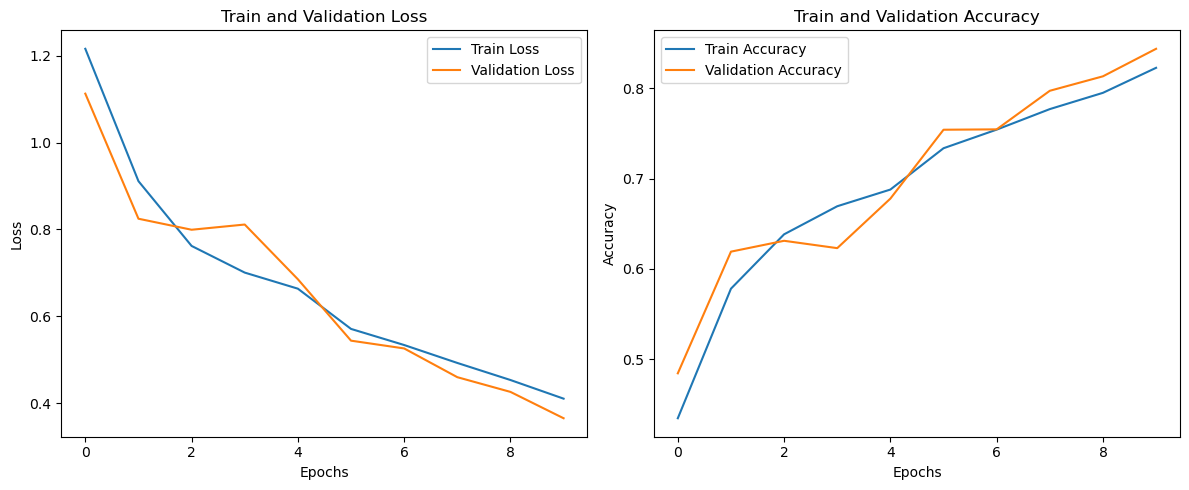

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

def train_model(model, train_loader, val_loader, epochs):
    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item()) 

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model_dense.pt")
            print(f"Saved best model with Val Acc: {best_val_acc:.4f}")

        
        scheduler.step()

    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

train_model(model, train_loader, val_loader, 10)


### Training/Validation Loss and Accuracy curves

### Testing the model

Testing: 100%|██████████████████████████████| 1062/1062 [03:54<00:00,  4.53it/s]


Test Accuracy: 0.8438

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.86      0.94      0.90      8960
ModerateDemented       1.00      1.00      1.00      6464
     NonDemented       0.85      0.71      0.77      9600
VeryMildDemented       0.72      0.78      0.75      8960

        accuracy                           0.84     33984
       macro avg       0.86      0.86      0.85     33984
    weighted avg       0.85      0.84      0.84     33984



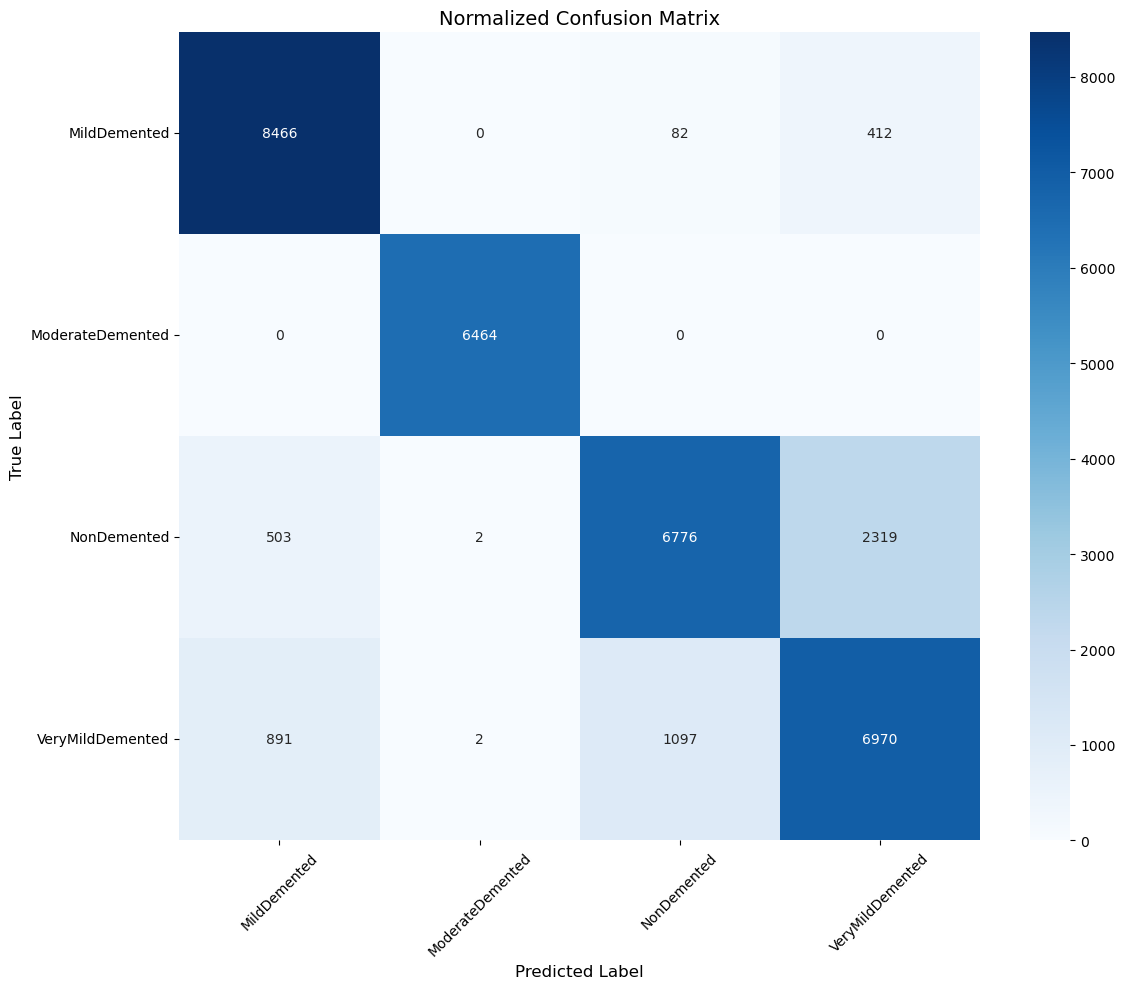

In [16]:
def test_model(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred, target_names=class_names)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{clf_report}")
    
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=class_names,  yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy

test_accuracy = test_model(model = model, test_loader = test_loader, device = device, class_names = test_data.classes)

### Random predictions made by the model

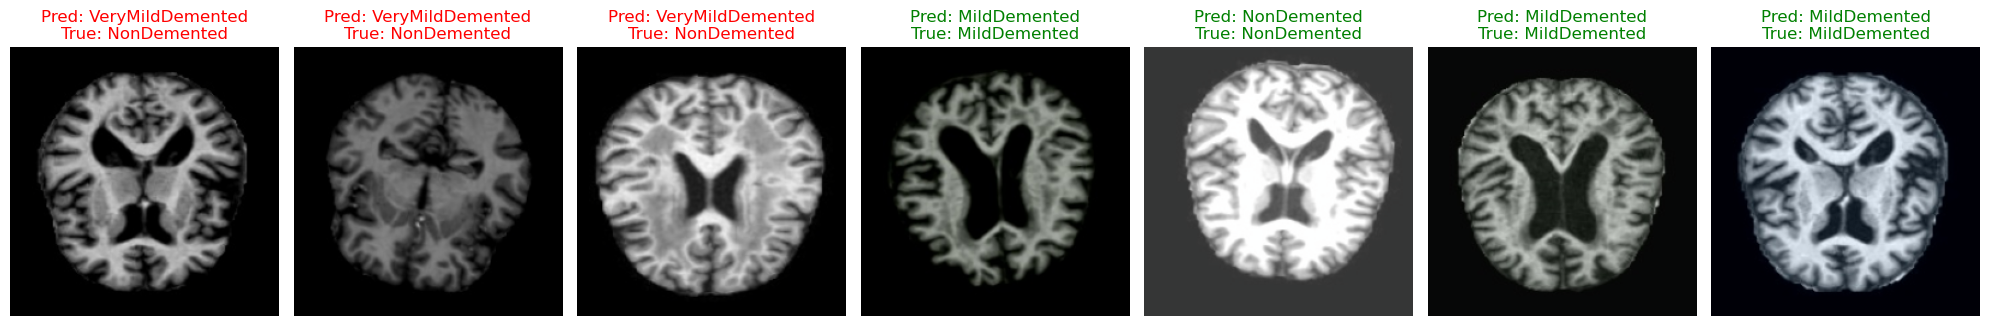

In [17]:
def visualize_random_predictions(model, data_loader, class_names, num_images=7):
    model.eval()
    class_samples = {class_idx: [] for class_idx in range(len(class_names))}
    for images, labels in data_loader:
        for img, label in zip(images, labels):
            if len(class_samples[label.item()]) < num_images:
                class_samples[label.item()].append((img, label))
        if all(len(v) >= num_images for v in class_samples.values()):
            break
    selected_samples = []
    for class_idx in class_samples:
        selected_samples.extend(random.sample(class_samples[class_idx], min(num_images, len(class_samples[class_idx]))))
    random.shuffle(selected_samples)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]
    
    for (img, true_label), ax in zip(selected_samples[:num_images], axes):
        img = img.to(device)
        img_np = img.cpu().numpy().transpose((1, 2, 0))
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        with torch.no_grad():
            output = model(img.unsqueeze(0))
            _, pred = torch.max(output, 1)
        
        ax.imshow(img_np)
        ax.set_title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[true_label.item()]}", 
                    fontsize=12, color='green' if pred == true_label else 'red')
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
visualize_random_predictions(model, val_loader, class_names, num_images=7)